In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from pandas.tseries.offsets import DateOffset
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import math
import warnings
warnings.filterwarnings("ignore")

In [45]:
df = pd.read_csv('https://raw.githubusercontent.com/jbrownlee/Datasets/master/shampoo.csv')

In [46]:
df.head()

,Month,Sales
0,1-01,266.0
1,1-02,145.9
2,1-03,183.1
3,1-04,119.3
4,1-05,180.3


In [47]:
df.tail()

,Month,Sales
31,3-08,407.6
32,3-09,682.0
33,3-10,475.3
34,3-11,581.3
35,3-12,646.9


######  Data refers from Jan 2001 to Dec 2003. It’’s a monthly sales data. Creating monthly dates for timestamp from Jan 2001 to Dec 2003.

In [48]:
date = pd.date_range(start='1/1/2001', end='12/31/2003', freq='M')
date

DatetimeIndex(['2001-01-31', '2001-02-28', '2001-03-31', '2001-04-30',
               '2001-05-31', '2001-06-30', '2001-07-31', '2001-08-31',
               '2001-09-30', '2001-10-31', '2001-11-30', '2001-12-31',
               '2002-01-31', '2002-02-28', '2002-03-31', '2002-04-30',
               '2002-05-31', '2002-06-30', '2002-07-31', '2002-08-31',
               '2002-09-30', '2002-10-31', '2002-11-30', '2002-12-31',
               '2003-01-31', '2003-02-28', '2003-03-31', '2003-04-30',
               '2003-05-31', '2003-06-30', '2003-07-31', '2003-08-31',
               '2003-09-30', '2003-10-31', '2003-11-30', '2003-12-31'],
              dtype='datetime64[ns]', freq='M')

In [49]:
df['Time_Stamp'] = pd.DataFrame(date,columns=['Date'])
df.head()

,Month,Sales,Time_Stamp
0,1-01,266.0,2001-01-31
1,1-02,145.9,2001-02-28
2,1-03,183.1,2001-03-31
3,1-04,119.3,2001-04-30
4,1-05,180.3,2001-05-31


In [50]:
df = df.set_index('Time_Stamp')
df.head()

,Month,Sales
Time_Stamp,,
2001-01-31,1-01,266.0
2001-02-28,1-02,145.9
2001-03-31,1-03,183.1
2001-04-30,1-04,119.3
2001-05-31,1-05,180.3


In [51]:
df.drop('Month',axis=1,inplace=True)
df.head()

,Sales
Time_Stamp,
2001-01-31,266.0
2001-02-28,145.9
2001-03-31,183.1
2001-04-30,119.3
2001-05-31,180.3


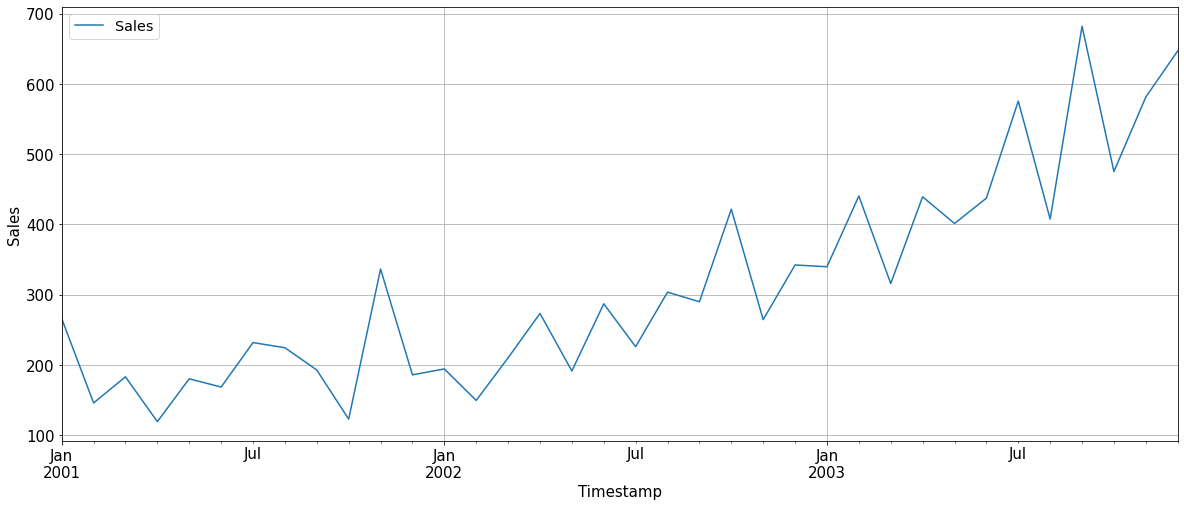

In [52]:
df.plot(figsize=(20,8))
plt.grid();
plt.xlabel('Timestamp',fontsize=15)
plt.ylabel('Sales',fontsize=15)
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
plt.legend(fontsize="x-large")

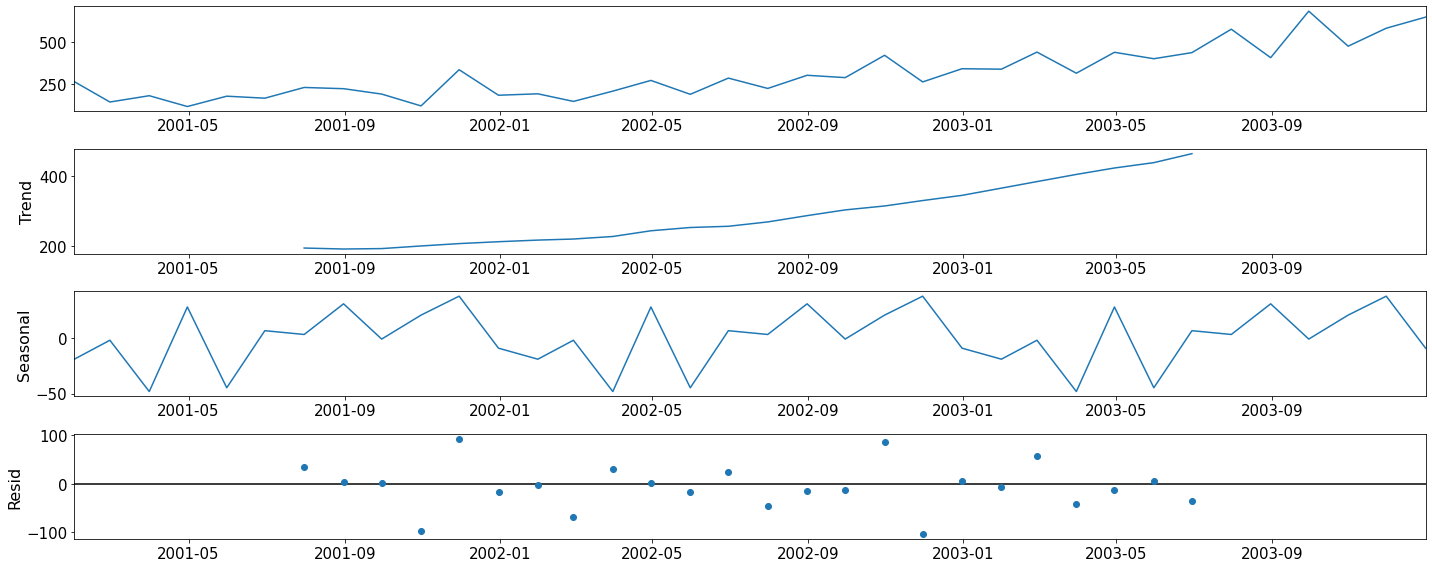

In [53]:
decomposition = seasonal_decompose(df, model = 'additive')
fig = decomposition.plot()
plt.show()

plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.figsize'] = 20, 8

In [54]:
adftest = adfuller(df)
print('Pvalue of adfuller test is:', adftest[1])

Pvalue of adfuller test is: 1.0


do not reject null hypothesis, ts is not stationary

#### Train test split

In [55]:
len(df)

36

(<Figure size 1440x576 with 1 Axes>,)

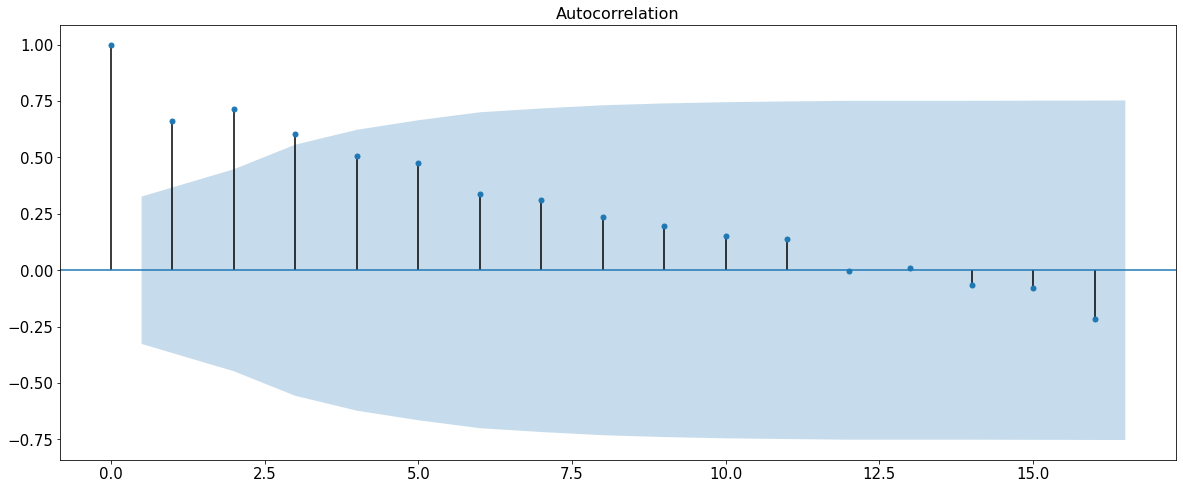

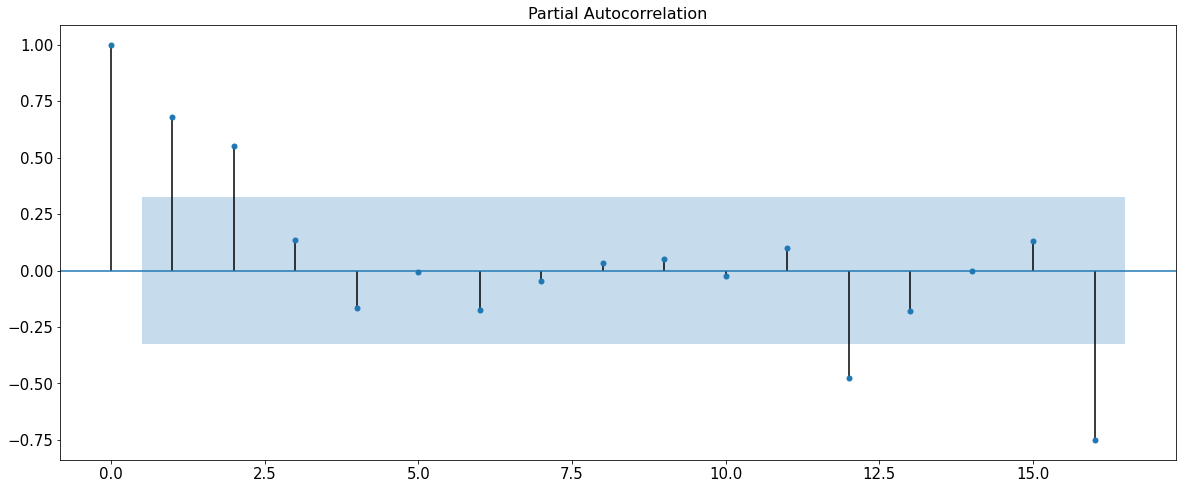

In [57]:
plot_acf(df),
plot_pacf(df),

#### Differencing

In [58]:
df['Sales First Difference'] = df['Sales'] - df['Sales'].shift(1)

In [59]:
df.head()

,Sales,Sales First Difference
Time_Stamp,,
2001-01-31,266.0,NaN
2001-02-28,145.9,-120.1
2001-03-31,183.1,37.2
2001-04-30,119.3,-63.8
2001-05-31,180.3,61.0


In [62]:

df['Sales First Difference'].dropna( inplace=True)
adftest = adfuller(df['Sales First Difference'])
print('Pvalue of adfuller test is:', adftest[1])

Pvalue of adfuller test is: 1.7998574141687034e-10


#### Log Transforming the dataset to make it Stationary

In [60]:
df['Sales_log']=np.log(df['Sales'])
df.head()

,Sales,Sales First Difference,Sales_log
Time_Stamp,,,
2001-01-31,266.0,NaN,5.583496
2001-02-28,145.9,-120.1,4.982921
2001-03-31,183.1,37.2,5.210032
2001-04-30,119.3,-63.8,4.781641
2001-05-31,180.3,61.0,5.194622


In [63]:
df['Sales_log'].dropna( inplace=True)
adftest = adfuller(df['Sales_log'])
print('Pvalue of adfuller test is:', adftest[1])

Pvalue of adfuller test is: 0.9983459643719065


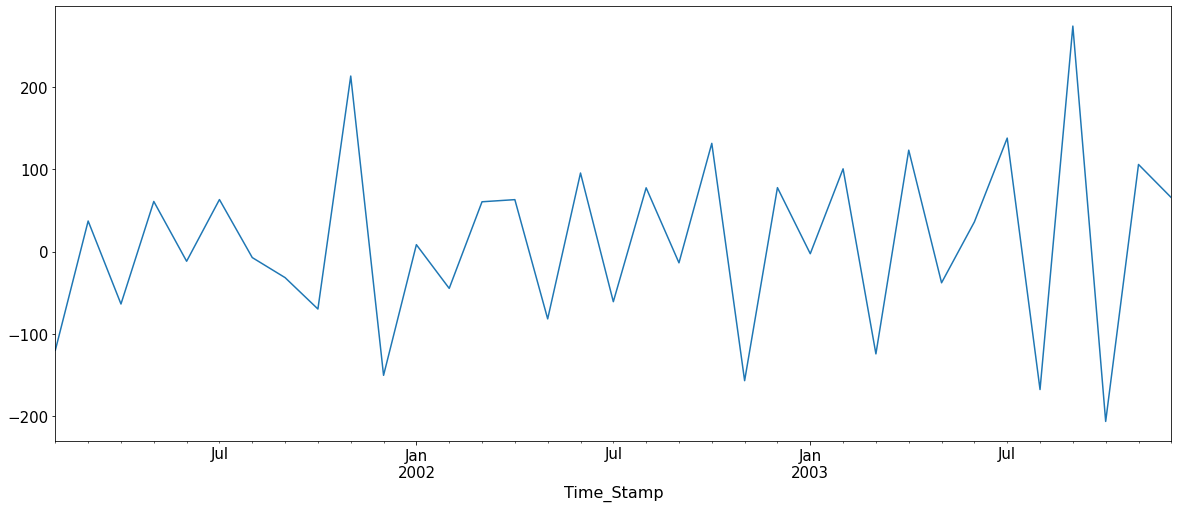

In [68]:
df['Sales First Difference'].plot(figsize=(20,8))

#### Build ARIMA model

In [144]:
import itertools

train = df[0:25]
test = df[25:36]

In [76]:
p = range(0, 3)
d = range(0, 2)
q = range(0, 3)

pdq_combination = list(itertools.product(p,d,q))
for pdq in pdq_combination:
    try:
        model = ARIMA(train, order =pdq).fit()
        pred = model.predict(start =len(train),end =(len(df)-1))
        error = np.sqrt(mean_squared_error(test, pred))
        #order1.append(pdq)
        #rmse.append(error)
        #results = mod.fit(max_iter = 50, method = 'powell')
        print('ARIMA{} - RMSE:{}'.format(pdq,error))
        #print('ARIMA{} - AIC:{}'.format(pdq, model.aic))
        
    except:
        continue

ARIMA(0, 0, 0) - RMSE:279.19554897207473
ARIMA(0, 0, 1) - RMSE:277.4042978173269
ARIMA(0, 0, 2) - RMSE:273.43662884719635
ARIMA(0, 1, 0) - RMSE:500.07019774115344
ARIMA(0, 1, 1) - RMSE:498.48141652771073
ARIMA(0, 1, 2) - RMSE:496.6122640847391
ARIMA(1, 0, 0) - RMSE:274.3654250290471
ARIMA(1, 0, 1) - RMSE:238.32191419294463
ARIMA(1, 0, 2) - RMSE:235.02118993926354
ARIMA(1, 1, 0) - RMSE:497.59690994790157
ARIMA(1, 1, 1) - RMSE:498.4200584973316
ARIMA(2, 0, 0) - RMSE:251.98447170892464
ARIMA(2, 0, 1) - RMSE:91.68100749296092
ARIMA(2, 1, 0) - RMSE:498.2175563706763
ARIMA(2, 1, 1) - RMSE:498.4190094544662
ARIMA(2, 1, 2) - RMSE:498.0173964934138


In [80]:
model_1 =ARIMA(train, order=(2,0,1)).fit()

In [81]:
pred_1= model_1.predict(start =len(train),end =(len(df)-1))

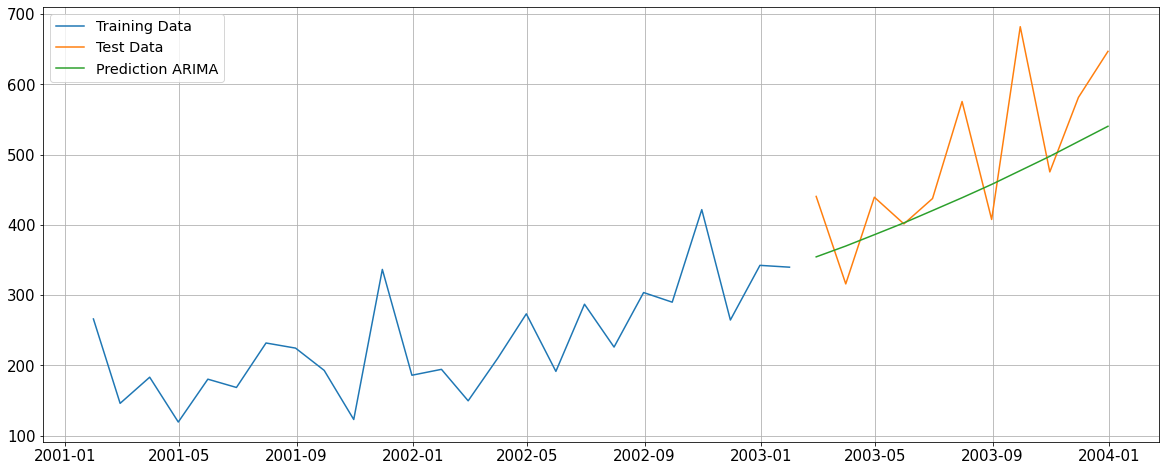

In [82]:
plt.plot(train,label='Training Data')
plt.plot(test,label='Test Data')
plt.plot(pred_1,label= 'Prediction ARIMA')
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.figsize'] = 20, 8
plt.legend(loc = 'best')
plt.legend(fontsize="x-large")
plt.grid()


#### SARIMA

In [164]:
p = range(0,3)
q = range(1,3)
d = range(0,3)
s = range(12,13)
# list of all parameter combos
pdq = list(itertools.product(p, d, q))

seasonal_pdq = list(itertools.product(p, d, q, s))

# SARIMA model pipeline
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            
            mod = sm.tsa.statespace.SARIMAX(train,
                                    order=param,
                                    seasonal_order=param_seasonal).fit()
        
            pred = mod.predict(start =len(train),end =(len(df)-1))
            error = np.sqrt(mean_squared_error(test, pred))
            #results = mod.fit(max_iter = 50, method = 'powell')
            
            #print('SARIMA{},{} - AIC:{}'.format(param, param_seasonal, results.aic))
            print('SARIMA{},{} - RMSE:{}'.format(param,param_seasonal,error))
           
        except:
            continue

In [172]:
model_sarima=sm.tsa.statespace.SARIMAX(train['Sales'],order=(0, 2, 2),seasonal_order=(2, 0, 1,12)).fit()
pred_sarima= model_sarima.predict(start =len(train),end =(len(df)-1))
model_sarima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                Sales   No. Observations:                   25
Model:             SARIMAX(0, 2, 2)x(2, 0, [1], 12)   Log Likelihood                -128.944
Date:                              Mon, 28 Feb 2022   AIC                            269.889
Time:                                      21:49:10   BIC                            276.702
Sample:                                  01-31-2001   HQIC                           271.602
                                       - 01-31-2003                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -1.7714      0.399     -4.438      0.000      -2.554      -0.989
ma.L2          0.8908      0.499      1.785      0.074      -0.087       1.869
ar.S.L12      -0.7356      5.027     -0.146      0.884     -10.589       9.118
ar.S.L24      -0.5466      5.130     -0.107      0.915     -10.600       9.507
ma.S.L12      -0.9990     11.483     -0.087      0.931     -23.506      21.508
sigma2       795.2836      0.014    5.5e+04      0.000     795.255     795.312
===================================================================================
Ljung-Box (Q):                       10.85   Jarque-Bera (JB):                 0.77
Prob(Q):                              0.98   Prob(JB):                         0.68
Heteroskedasticity (H):               1.19   Skew:                            -0.44
Prob(H) (two-sided):                  0.81   Kurtosis:                         3.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.01e+22. Standard errors may be unstable.
"""

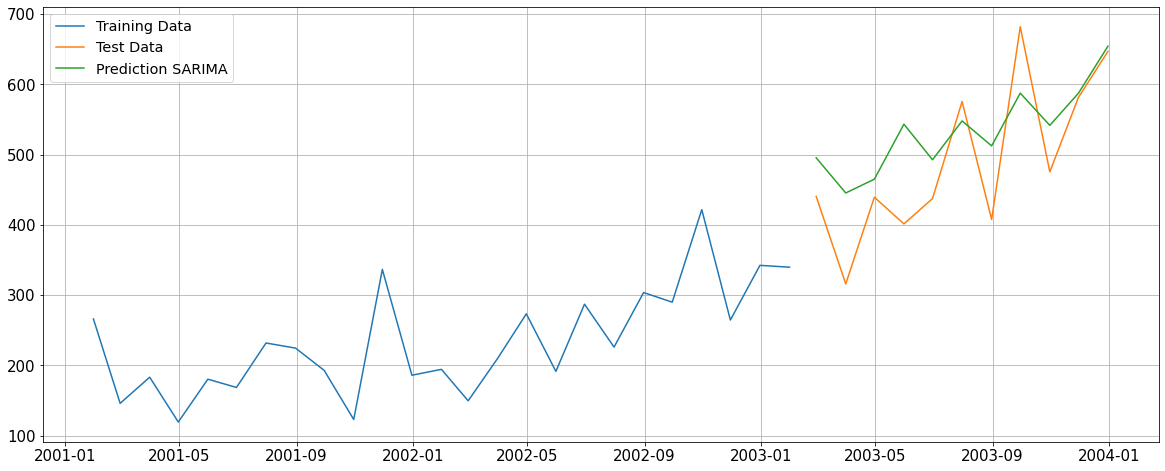

In [173]:
plt.plot(train['Sales'],label='Training Data')
plt.plot(test['Sales'],label='Test Data')
plt.plot(pred_sarima,label= 'Prediction SARIMA')
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.figsize'] = 20, 8
plt.legend(loc = 'best')
plt.legend(fontsize="x-large")
plt.grid()

In [177]:
def rmse(t, y):
    return np.sqrt(np.mean((t-y)**2))

In [179]:
print('RMSE :', rmse(test['Sales'],pred_sarima))

RMSE : 79.07079151118086


#### Predict Future Data(3-years)

In [150]:
from pandas.tseries.offsets import DateOffset
future_dates =[df.index[-1]+DateOffset(months= x)for x in range(0,37)]

future_dataset_df =pd.DataFrame(index=future_dates[1:],columns=df.columns)

In [151]:
future_dataset_df.head()

,Sales,Sales First Difference,Sales_log
2004-01-31,NaN,NaN,NaN
2004-02-29,NaN,NaN,NaN
2004-03-31,NaN,NaN,NaN
2004-04-30,NaN,NaN,NaN
2004-05-31,NaN,NaN,NaN


In [152]:
future_df = pd.concat([df,future_dataset_df])

In [153]:
future_df.index.name ='Time Stamp'
future_df.tail()

,Sales,Sales First Difference,Sales_log
Time Stamp,,,
2006-08-31,NaN,NaN,NaN
2006-09-30,NaN,NaN,NaN
2006-10-31,NaN,NaN,NaN
2006-11-30,NaN,NaN,NaN
2006-12-31,NaN,NaN,NaN


In [174]:
start_date =len(train)

end_date = len(future_df)-25
prediction_new = model_sarima.predict(start = start_date,end = end_date)


In [175]:
prediction_new

2003-02-28    495.355495
2003-03-31    445.331271
2003-04-30    464.937202
2003-05-31    543.220077
2003-06-30    492.565830
2003-07-31    547.886164
2003-08-31    512.370154
2003-09-30    587.435839
2003-10-31    541.542180
2003-11-30    587.248548
2003-12-31    654.288233
2004-01-31    663.236896
2004-02-29    610.517579
2004-03-31    643.089736
2004-04-30    623.021250
2004-05-31    639.106518
2004-06-30    653.010055
2004-07-31    674.561817
2004-08-31    687.169128
2004-09-30    668.340748
2004-10-31    659.009077
2004-11-30    740.163973
2004-12-31    677.222781
Freq: M, dtype: float64

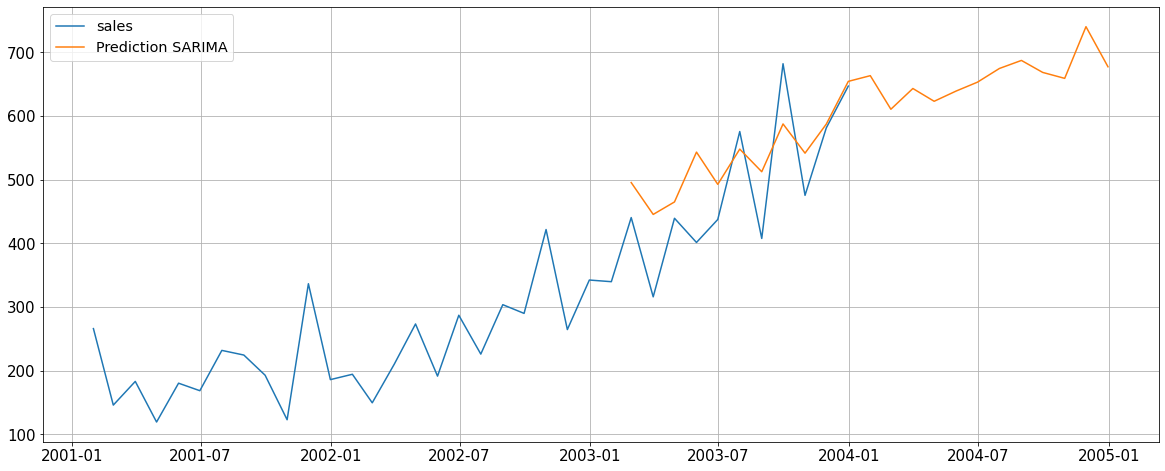

In [176]:
plt.plot(df['Sales'],label='sales')
#plt.plot(test['Sales'],label='Test Data')
plt.plot(prediction_new,label= 'Prediction SARIMA')
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 16
plt.rcParams['figure.figsize'] = 20, 8
plt.legend(loc = 'best')
plt.legend(fontsize="x-large")
plt.grid()